# TLJ Topic Modeling - Latent Dirichlet Allocation

In [145]:
import pandas as pd
import numpy as np
import re 
from pprint import pprint

import pickle


# import string


# from sklearn.feature_extraction.text import CountVectorizer

# from textblob import TextBlob

import nltk, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.util import *

# from sklearn.metrics import accuracy_score, confusion_matrix

# from confusion import print_confusion_matrix

# import random

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from pprint import pprint


In [146]:
# Import tlj df pickle
tlj_all = pickle.load(open('tlj_v2.pickle', 'rb'))

In [147]:
# Create NLTK stopwords
stop_words = stopwords.words('english')

## LDA Topic Modeling 
Now we'll attempt to find topics with LDA in the negative reviews only, our main area of focus

In [148]:
# Create DataFrame where that only has negative sentiment reviews
tlj = tlj_all.loc[tlj_all['google_sentiment']=='negative']

In [149]:
# Create list of tokenized negative documents
tlj_data = [data['Tokens'] for index, data in tlj.iterrows()]

In [150]:
# Build bigrams and trigram models
bigram = gensim.models.Phrases(tlj_data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tlj_data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [151]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return[[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [152]:
# Remove stop words
tlj_data_nostops = remove_stopwords(tlj_data)

In [153]:
# Create Bigrams
tlj_data_bigrams = make_bigrams(tlj_data_nostops)

In [154]:
# Create Trigrams
tlj_data_trigrams = make_trigrams(tlj_data_nostops)

In [155]:
# Initialize spaCy 'en' model, keeping only tagger component
nlp = spacy.load('en', disable=['parser', 'ner'])

In [156]:
# Lemmatize with bigrams, keeping only noun, adj, vb, adv
tlj_data_bigram_lemmatized = lemmatization(tlj_data_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [157]:
# Lemmatize with trigrams, keeping only noun, adj, vb, adv
tlj_data_trigram_lemmatized = lemmatization(tlj_data_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create Dictionary and Corpus for Topic Modeling

In [158]:
# Create Dictionary with bigrams
id2word = corpora.Dictionary(tlj_data_bigram_lemmatized)

# Create Corpus
texts = tlj_data_bigram_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Check out!
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 5), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 2), (45, 1), (46, 9), (47, 1), (48, 1), (49, 4), (50, 2), (51, 4), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 9), (70, 4), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 1), (80, 5), (81, 1), (82, 4), (83, 1), (84, 1), (85, 1), (86, 1), (87, 4), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 1)

In [159]:
# Look for a word that appears a lot
id2word[46]

'force'

In [160]:
# Create a human-readable version of the corpus to easily see words and their frequency
corpus_readable = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [161]:
corpus_readable[0]

[('ability', 1),
 ('actually', 1),
 ('alive', 1),
 ('anakin', 1),
 ('apparent', 1),
 ('appear', 2),
 ('army', 1),
 ('attempt', 1),
 ('awaken', 1),
 ('away', 1),
 ('back', 1),
 ('bare', 1),
 ('become', 1),
 ('behaviour', 1),
 ('ben', 1),
 ('big', 1),
 ('bloody', 1),
 ('breaker', 1),
 ('bring', 1),
 ('call', 1),
 ('casino', 1),
 ('cell', 1),
 ('character', 2),
 ('characterisation', 1),
 ('code', 1),
 ('code_breaker', 1),
 ('come', 1),
 ('comedy', 1),
 ('completely', 1),
 ('could', 2),
 ('day', 1),
 ('deus_ex', 1),
 ('dice', 1),
 ('die', 1),
 ('earlier', 1),
 ('entire', 2),
 ('even', 5),
 ('eye', 1),
 ('fall', 1),
 ('fantastic', 1),
 ('feel', 1),
 ('feminist', 1),
 ('fight', 1),
 ('find', 2),
 ('finn', 2),
 ('first', 1),
 ('force', 9),
 ('frozen', 1),
 ('gang', 1),
 ('get', 4),
 ('ghost', 2),
 ('go', 4),
 ('happen', 1),
 ('harry_potter', 1),
 ('heck', 1),
 ('immediately', 1),
 ('inane', 1),
 ('intergalactically', 1),
 ('invent', 1),
 ('kylo', 1),
 ('last', 2),
 ('leia', 1),
 ('light', 1),

## Build the LDA Topic Model

In [162]:
# Build LDA model. Using some default parameters here. Will probably tweak.

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

## Compute Model Perplexity & Coherence
- Compute perplexity, the log-likelihood of the documents given the topics and distribution. The lower the better.
- For this to be meaningful though we'll need to compare it to other models with different k's. 

In [163]:
# Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))
print()

# Coherence
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=tlj_data_bigram_lemmatized, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence: ', coherence_lda)

Perplexity:  -9.972058301786278

Coherence:  0.4657004313893228


- Below are the numbers for the model with all reviews, not simply the negative ones:
    - Perplexity: -10.017601025672002
    - Coherence: 0.4368785592491428
- So slightly worse Perplexity and slightly better Coherence with the negative-only model. However, this is with absolutely no adjustments between the two in terms of tokenization, lemmatization and LDA model parameters. 
- Let's see if the topics themsevles sort out any better. 

## Topics list for negative-only sentiment

In [165]:
# Print keywords in topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.092*"user" + 0.075*"imdb" + 0.047*"badly" + 0.031*"exception" + '
  '0.031*"flick" + 0.025*"up" + 0.025*"business" + 0.020*"shin" + 0.018*"defy" '
  '+ 0.017*"reading"'),
 (1,
  '0.059*"criticism" + 0.048*"light_speed" + 0.047*"starwar" + 0.032*"droid" + '
  '0.030*"immediately" + 0.022*"confrontation" + 0.021*"disaster" + '
  '0.021*"plothole" + 0.021*"swing" + 0.018*"express"'),
 (2,
  '0.053*"film" + 0.040*"character" + 0.020*"new" + 0.020*"last" + '
  '0.016*"story" + 0.013*"jedi" + 0.011*"feel" + 0.011*"trilogy" + '
  '0.011*"plot" + 0.010*"awaken"'),
 (3,
  '0.099*"visually" + 0.000*"wise" + 0.000*"impressive" + 0.000*"dramatic" + '
  '0.000*"equally" + 0.000*"fresh" + 0.000*"stick" + 0.000*"acceptable" + '
  '0.000*"curious" + 0.000*"pleasant"'),
 (4,
  '0.054*"ship" + 0.049*"order" + 0.049*"space" + 0.038*"first" + '
  '0.029*"rebel" + 0.028*"resistance" + 0.023*"plan" + 0.020*"escape" + '
  '0.016*"chase" + 0.016*"fly"'),
 (5,
  '0.064*"salt" + 0.052*"intention" + 0.

__NOTE:__ The ordering of the topic list above is random. The ordering of the topics does not imply its relative importance.

## Visualize with pyLDAvis

In [166]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.414648 -0.086929       1        1  39.994873
2     -0.374860 -0.104590       2        1  26.873896
17    -0.369630  0.207599       3        1  15.425487
18    -0.341857 -0.273937       4        1  10.994715
4     -0.250893  0.331521       5        1   4.757601
1      0.085143 -0.001797       6        1   0.419507
7      0.088081 -0.002227       7        1   0.350877
10     0.087859 -0.002201       8        1   0.334494
0      0.095820 -0.003434       9        1   0.321877
19     0.119176 -0.005825      10        1   0.157301
16     0.124327 -0.006180      11        1   0.126820
5      0.126095 -0.006261      12        1   0.113729
11     0.129119 -0.005961      13        1   0.041586
13     0.129131 -0.005991      14        1   0.033760
3      0.128968 -0.005947      15        1   0.024697
6      0.128115 -0.005681      16        1   0.010829
12     0.127513 -0.005540      17        1   0.004657
9      0.127513 -0.005540      18        1   0.004493
14     0.127513 -0.005540      19        1   0.004425
15     0.127513 -0.005540      20        1   0.004375, topic_info=     Category          Freq             Term         Total  loglift  logprob
term                                                                        
114   Default  10007.000000             star  10007.000000  30.0000  30.0000
135   Default   9290.000000              war   9290.000000  29.0000  29.0000
77    Default  13335.000000            movie  13335.000000  28.0000  28.0000
66    Default   6598.000000             luke   6598.000000  27.0000  27.0000
192   Default   7533.000000             film   7533.000000  26.0000  26.0000
95    Default   3938.000000              rey   3938.000000  25.0000  25.0000
189   Default   3155.000000              fan   3155.000000  24.0000  24.0000
22    Default   6637.000000        character   6637.000000  23.0000  23.0000
45    Default   3070.000000            first   3070.000000  22.0000  22.0000
46    Default   5001.000000            force   5001.000000  21.0000  21.0000
175   Default   2162.000000           disney   2162.000000  20.0000  20.0000
645   Default   3237.000000              bad   3237.000000  19.0000  19.0000
86    Default   1574.000000            order   1574.000000  18.0000  18.0000
104   Default   1371.000000             ship   1371.000000  17.0000  17.0000
109   Default   2238.000000            snoke   2238.000000  16.0000  16.0000
111   Default   1342.000000            space   1342.000000  15.0000  15.0000
51    Default   4640.000000               go   4640.000000  14.0000  14.0000
101   Default   4943.000000              see   4943.000000  13.0000  13.0000
59    Default   1621.000000             kylo   1621.000000  12.0000  12.0000
576   Default   3094.000000            think   3094.000000  11.0000  11.0000
71    Default   5246.000000             make   5246.000000  10.0000  10.0000
44    Default   1713.000000             finn   1713.000000   9.0000   9.0000
272   Default   2050.000000            watch   2050.000000   8.0000   8.0000
60    Default   3375.000000             last   3375.000000   7.0000   7.0000
245   Default   1088.000000       resistance   1088.000000   6.0000   6.0000
61    Default   1556.000000             leia   1556.000000   5.0000   5.0000
516   Default   2812.000000           really   2812.000000   4.0000   4.0000
80    Default   3741.000000              new   3741.000000   3.0000   3.0000
96    Default   1402.000000             rise   1402.000000   2.0000   2.0000
197   Default   5482.000000             good   5482.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
7889  Topic20      0.001232            that´      0.502097   4.0267  -9.8484
6320  Topic20      0.001232      contrivance      0.502098   4.0267  -9.8484
6304  Topic20      0.001232             winy      0.502096   4.0267  -9.84

- Similar pattern here to the all topics version, though there is at least one clearly discernable topic here in topic 4. This one seems to revolve around 'meta' factors external to the film content. It mentions the studio (disney), the word "franchise", "director", those directors' names ("rian_johnson", "abram", "george_lucas"), "money", and an assortment of negative words ("bad", "ruin", "destroy", etc.)
    - I would loosely call this topic "Franchise Stewardship", meaning concerns over who is in charge of the Star Wars franchise and the decisions they're making. That is certainly a topic within Star Wars fandom. It was there for The Force Awakens, but greatly amplified after The Last Jedi. 
- Topic 5 is definitely vague, but more discernable for someone familiar with the movie and the complaints about it. It revolves around many issues perceived in the core plot thread, with the resistance running from the First Order. The bombing run in the opening battle ("bomber"), the chase scenario ("chase", "escape", "run", "fuel"), the lightspeed attack against the First Order's flagship ("light", "jump", "destroy"), Leia's flight scene ("fly", "leia", "space", "survive").
    - Would call this topic "Plot Issues", which is a REALLY broad definition. I would really like those complaints broken up into topics themselves somehow.

## Find the best model by trying several different topic numbers

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=tlj_data_bigram_lemmatized, 
                                                        start=2, limit=42, step=4)

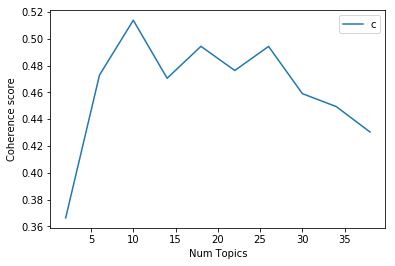

In [39]:
# Show graph
limit=42; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =",m, " has a Coherence of", round(cv,4))

Num Topics = 2  has a Coherence of 0.3663
Num Topics = 6  has a Coherence of 0.4729
Num Topics = 10  has a Coherence of 0.5138
Num Topics = 14  has a Coherence of 0.4705
Num Topics = 18  has a Coherence of 0.4943
Num Topics = 22  has a Coherence of 0.4763
Num Topics = 26  has a Coherence of 0.4942
Num Topics = 30  has a Coherence of 0.459
Num Topics = 34  has a Coherence of 0.4494
Num Topics = 38  has a Coherence of 0.4304


- Aha! This is informative. It would seem that coherence tops out at ~0.51 with __10 topics__.
- Let's plug in 10 topics to the model, instead of the previous 20, and see what the results are.

In [49]:
# Select the optimum model and print topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.031*"market" + 0.031*"product" + 0.014*"throne" + 0.014*"screenplay" + '
  '0.014*"video" + 0.013*"wall" + 0.012*"proud" + 0.011*"science" + '
  '0.011*"teen" + 0.010*"l"'),
 (1,
  '0.029*"listen" + 0.021*"depict" + 0.021*"transport" + '
  '0.019*"action_sequence" + 0.017*"dreadnaught" + 0.017*"light_spe" + '
  '0.015*"sneak" + 0.012*"ice" + 0.011*"critic_review" + 0.010*"bag"'),
 (2,
  '0.036*"film" + 0.027*"war" + 0.027*"star" + 0.024*"character" + '
  '0.015*"last" + 0.015*"new" + 0.011*"story" + 0.010*"fan" + 0.010*"jedi" + '
  '0.008*"force"'),
 (3,
  '0.056*"brilliant" + 0.031*"flesh" + 0.028*"troll" + 0.023*"budget" + '
  '0.014*"communicate" + 0.010*"worthwhile" + 0.007*"mouse" + 0.006*"cat" + '
  '0.000*"countdown" + 0.000*"imbd"'),
 (4,
  '0.047*"luke" + 0.030*"rey" + 0.022*"force" + 0.017*"snoke" + 0.013*"first" '
  '+ 0.013*"finn" + 0.012*"kylo" + 0.011*"leia" + 0.010*"order" + '
  '0.010*"rise"'),
 (5,
  '0.020*"con" + 0.019*"faith" + 0.018*"painful" + 0.017*"ima

In [50]:
# Display model results plot
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.389584  0.109695       1        1  37.747173
2      0.333858  0.167636       2        1  36.962299
4      0.319053 -0.299174       3        1  23.992668
5     -0.149536  0.003170       4        1   0.643725
7     -0.153690  0.002781       5        1   0.216223
0     -0.152089  0.003077       6        1   0.168062
1     -0.151968  0.003088       7        1   0.156724
3     -0.148900  0.003220       8        1   0.085409
9     -0.144440  0.003261       9        1   0.023212
6     -0.141872  0.003246      10        1   0.004509, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
77     Default  12255.000000            movie  12255.000000  30.0000  30.0000
66     Default   6332.000000             luke   6332.000000  29.0000  29.0000
192    Default   7006.000000             film   7006.000000  28.0000  28.0000
95     Default   3778.000000              rey   3778.000000  27.0000  27.0000
109    Default   2148.000000            snoke   2148.000000  26.0000  26.0000
135    Default   7592.000000              war   7592.000000  25.0000  25.0000
114    Default   8218.000000             star   8218.000000  24.0000  24.0000
645    Default   2932.000000              bad   2932.000000  23.0000  23.0000
46     Default   4714.000000            force   4714.000000  22.0000  22.0000
576    Default   2921.000000            think   2921.000000  21.0000  21.0000
60     Default   3090.000000             last   3090.000000  20.0000  20.0000
44     Default   1624.000000             finn   1624.000000  19.0000  19.0000
101    Default   4628.000000              see   4628.000000  18.0000  18.0000
516    Default   2659.000000           really   2659.000000  17.0000  17.0000
59     Default   1555.000000             kylo   1555.000000  16.0000  16.0000
71     Default   4844.000000             make   4844.000000  15.0000  15.0000
197    Default   5132.000000             good   5132.000000  14.0000  14.0000
61     Default   1458.000000             leia   1458.000000  13.0000  13.0000
22     Default   6248.000000        character   6248.000000  12.0000  12.0000
86     Default   1334.000000            order   1334.000000  11.0000  11.0000
96     Default   1318.000000             rise   1318.000000  10.0000  10.0000
126    Default   2264.000000            thing   2264.000000   9.0000   9.0000
51     Default   4364.000000               go   4364.000000   8.0000   8.0000
80     Default   3463.000000              new   3463.000000   7.0000   7.0000
49     Default   3515.000000              get   3515.000000   6.0000   6.0000
104    Default   1119.000000             ship   1119.000000   5.0000   5.0000
45     Default   2776.000000            first   2776.000000   4.0000   4.0000
272    Default   1858.000000            watch   1858.000000   3.0000   3.0000
250    Default   2556.000000              say   2556.000000   2.0000   2.0000
228    Default   2116.000000           people   2116.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
18927  Topic10      0.001269        originial      0.485015   4.0613  -9.8484
6320   Topic10      0.001269      contrivance     13.495572   0.7354  -9.8484
6304   Topic10      0.001269             winy      0.476984   4.0780  -9.8484
6305   Topic10      0.001269        firepower      0.496658   4.0376  -9.8484
6306   Topic10      0.001269       malcontent      0.477041   4.0779  -9.8484
6307   Topic10      0.001269        withstand      0.490730   4.0496  -9.8484
6308   Topic10      0.001269          zooming      0.478344   4.0752  -9.8484
6309   Topic10      0.001269         breaking      0.484390   4.0626  -9.8484
6310   Topic10      0.001269       aficionado      0.480006   4.0717  -9.8484
6311   Topic10      0.001269     

- Interesting. Even though this is the optimum coherence model, the separation seems to be much worse. We have 7 of the 10 all overlapping each other in one small corner of the distribution. 
- Additionally, the it's much harder to discern topic meaning. More work is needed. 

# GridSearchCV Approach with LDA

### Create the Document-Word Matrix using CountVectorizer

In [75]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df=10, 
                             stop_words='english',
                             lowercase=True, 
                             token_pattern='[a-zA-Z0-9]{3,}',
                             )
data_vectorized=vectorizer.fit_transform(list(tlj['Reviews']))  # Use a list of the full documents as the input, not the tokens

### Build the Sklearn LDA model

In [81]:
skl_lda_model = LatentDirichletAllocation(n_topics=20,        # Let's start on the higher end of topics
                                         max_iter=10, 
                                         learning_method='online',
                                         random_state=100, 
                                         batch_size=128, 
                                         evaluate_every= -1,  # Don't compute perplexity with every iteration
                                         n_jobs  = -1         # Use all available CPUs
                                         )        

skl_lda_output = skl_lda_model.fit_transform(data_vectorized)

In [128]:
skl_lda_output.diagonal()

array([6.60674357e-01, 2.35849057e-04, 6.84931521e-05, 1.38888889e-03,
       8.33333334e-04, 5.24084190e-02, 6.10079306e-01, 1.38888889e-04,
       1.04166667e-03, 3.12500016e-03, 2.08333335e-03, 1.21951222e-03,
       6.18490489e-02, 6.25000000e-04, 1.57569485e-02, 3.96825402e-04,
       1.31578947e-03, 9.43396226e-04, 1.28205128e-03, 2.27272727e-03])

### Evaluate Perplexity and Log-Likelihood
- Looking for high log-likelihood and low perpliexity.

In [89]:
print("Log-Likelihood: ", skl_lda_model.score(data_vectorized))


print("Perplexity: ", skl_lda_model.perplexity(data_vectorized))
pprint(skl_lda_model.get_params)

Log-Likelihood:  -3388059.620263419
Perplexity:  1362.9068952282096
<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)>


### Use GridSearch to find the best LDA Model

In [91]:
# Define Search Params
search_params = {'n_components': [5, 10, 15, 20, 25, 30, 35, 40], 'learning_decay': [.5, .7, .9]} # Search broadly, then narrow

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=5)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [5, 10, 15, 20, 25, 30, 35, 40], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
# # Pickle model! It took a LONG time to run. 
# pickle.dump(model, open('SKL_LDA_GridSearch_Model_v1.pickle', 'wb'))

### View the best topic model and parameters

In [98]:
# Best Model
skl_best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood: ", model.best_score_)

# Perplextiy 
print("Model Perplexity: ", skl_best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood:  -703906.862781201
Model Perplexity:  1264.3022074444043


In [119]:
model.best_estimator_.

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Plot different topic numbers per learning decay

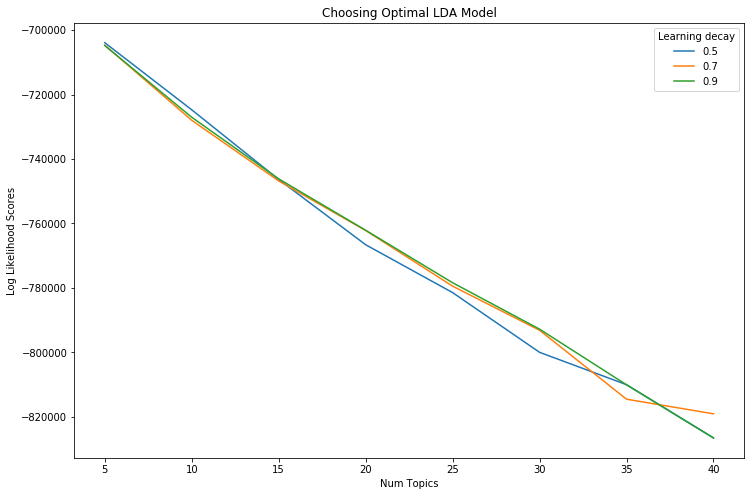

In [112]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20, 25, 30, 35, 40]

log_likelyhoods_5 = np.round(model.cv_results_['mean_test_score'][0:8])
log_likelyhoods_7 = np.round(model.cv_results_['mean_test_score'][8:16])
log_likelyhoods_9 = np.round(model.cv_results_['mean_test_score'][16:])


# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [118]:
skl_best_lda_model.n_topics

In [126]:
model.

{'n_components': [5, 10, 15, 20, 25, 30, 35, 40],
 'learning_decay': [0.5, 0.7, 0.9]}

### See topic distributions across documents

In [120]:
# Create Document - Topic Matrix
lda_output = skl_best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(skl_best_lda_model.n_components)] # n_topics - > n_components

# index names
docnames = ["Doc" + str(i) for i in range(len(tlj_data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Show df of topic distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,1916
1,2,878
2,1,799
3,3,539
4,4,143


### Visualize Results

In [116]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(skl_best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       86.795937  311.888000       1        1  27.194860
1      190.013474 -198.376862       2        1  26.427789
3     -108.108002   80.320892       3        1  21.359839
2     -122.217766 -222.033844       4        1  15.849662
4      300.088623   82.634529       5        1   9.167849, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
2406  Default   5558.000000        luke   5558.000000  30.0000  30.0000
2151  Default   3745.000000        jedi   3745.000000  29.0000  29.0000
4415  Default   7438.000000        wars   7438.000000  28.0000  28.0000
3357  Default   3151.000000         rey   3151.000000  27.0000  27.0000
2613  Default  10181.000000       movie  10181.000000  26.0000  26.0000
3807  Default   7951.000000        star   7951.000000  25.0000  25.0000
1600  Default   3842.000000       force   3842.000000  24.0000  24.0000
1519  Default   5025.000000        film   5025.000000  23.0000  23.0000
2225  Default   2277.000000        kylo   2277.000000  22.0000  22.0000
1114  Default   2278.000000      disney   2278.000000  21.0000  21.0000
3708  Default   1870.000000       snoke   1870.000000  20.0000  20.0000
3598  Default    847.000000        ship    847.000000  19.0000  19.0000
3680  Default   1211.000000   skywalker   1211.000000  18.0000  18.0000
3283  Default   1339.000000         ren   1339.000000  17.0000  17.0000
4536  Default    770.000000        yoda    770.000000  16.0000  16.0000
926   Default    727.000000        dark    727.000000  15.0000  15.0000
1538  Default   1454.000000        finn   1454.000000  14.0000  14.0000
2294  Default   1543.000000        leia   1543.000000  13.0000  13.0000
2767  Default   1307.000000       order   1307.000000  12.0000  12.0000
3404  Default   1063.000000        rose   1063.000000  11.0000  11.0000
4170  Default    621.000000    training    621.000000  10.0000  10.0000
4335  Default    487.000000       vader    487.000000   9.0000   9.0000
3744  Default   1439.000000       space   1439.000000   8.0000   8.0000
338   Default    357.000000         ben    357.000000   7.0000   7.0000
2980  Default    545.000000    powerful    545.000000   6.0000   6.0000
3311  Default    871.000000  resistance    871.000000   5.0000   5.0000
1627  Default   1132.000000   franchise   1132.000000   4.0000   4.0000
3599  Default    482.000000       ships    482.000000   3.0000   3.0000
1525  Default    914.000000       films    914.000000   2.0000   2.0000
3721  Default    435.000000        solo    435.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
2816   Topic5     91.499091   palpatine    144.667208   1.9314  -6.1535
2406   Topic5   2189.192270        luke   5558.313979   1.4577  -2.9785
2455   Topic5    207.162022      master    380.106341   1.7825  -5.3363
926    Topic5    360.238886        dark    727.435778   1.6867  -4.7830
2151   Topic5   1218.883221        jedi   3745.029436   1.2670  -3.5641
1804   Topic5    213.136784         han    435.588758   1.6747  -5.3079
4170   Topic5    277.720210    training    621.906651   1.5833  -5.0432
2980   Topic5    239.893275    powerful    545.495965   1.5680  -5.1896
1600   Topic5   1069.878816       force   3842.530667   1.1109  -3.6945
3680   Topic5    437.802556   skywalker   1211.202521   1.3719  -4.5880
3357   Topic5    901.325548         rey   3151.317774   1.1378  -3.8659
3727   Topic5     69.511364         son    114.114239   1.8938  -6.4283
4169   Topic5     78.438310     trained    137.315903   1.8295  -6.3075
1694   Topic5     90.131102       ghost    171.390644   1.7468  -6.1685
3283   Topic5    365.748164         ren   1339.765400   1.0912  -4.7679
2978   Topic5    149.480439       power    367.185783   1.4908  -5.6626
2225   Topic5    489.18

- This has cleanly separated the topics, but they're completely uninterpretable now. Way too general. 

### View Topic Keywords

In [ ]:
df_topic_keywords = pd.DataFrame(skl_best_lda_model.components_)

df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

df_topic_keywords.head()

### Get Top Keywords in each Topic

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords=[]
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=skl_best_model, n_words=15)

In [ ]:
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywordsic_keywords.columns = ['Word'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

### Visualize Topic Clustering with K-Means
We'll use SVD to capture the 2 components with the greatest effect on clustering so we can visualize it as a plot.

In [124]:
# Construct k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(lda_output)

svd_model = TruncatedSVD(n_components=2) # 2 components for visualization
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component weights: \n", np.round(svd_model.components_, 2))

# Percentatge of total information in 'lda_output' explained by the two components
print("% of Variance Explained per Component: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component weights: 
 [[ 0.92  0.2   0.28  0.15  0.08]
 [-0.36  0.36  0.84  0.16  0.06]]
% of Variance Explained per Component: 
 [0.18 0.32]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

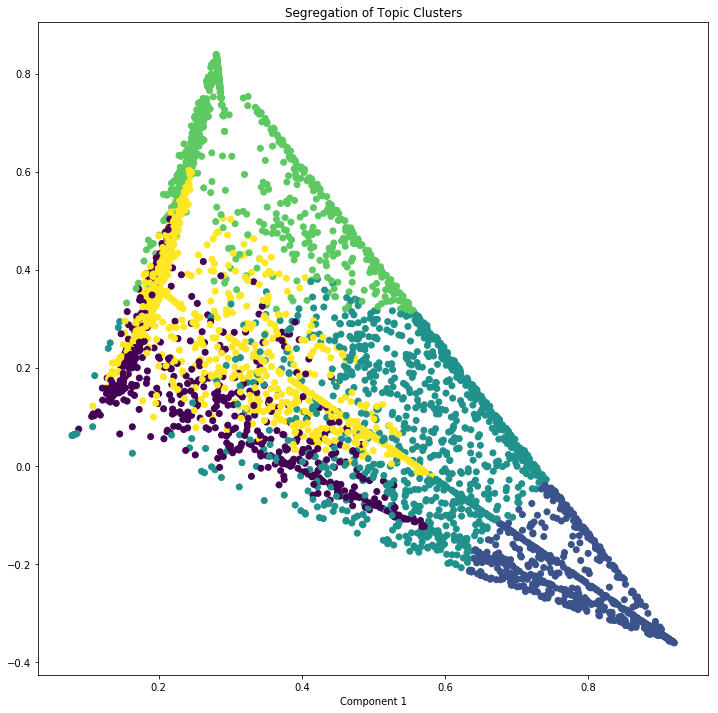

In [125]:
# Plot the clusters
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## Try Sklearn LDA with 10 and 20 topics

In [138]:
# 10 Topics
skl_lda_model_10 = LatentDirichletAllocation(n_topics=10,        # Let's start on the higher end of topics
                                         max_iter=10, 
                                         learning_method='online',
                                         random_state=100, 
                                         batch_size=128, 
                                         evaluate_every= -1,  # Don't compute perplexity with every iteration
                                         n_jobs  = -1         # Use all available CPUs
                                         )        

skl_lda_output_10 = skl_lda_model_10.fit_transform(data_vectorized)

In [139]:
# Log-Likelihood & Perplexity
print("Log-Likelihood: ", skl_lda_model_10.score(data_vectorized))


print("Perplexity: ", skl_lda_model_10.perplexity(data_vectorized))
pprint(skl_lda_model_10.get_params)

Log-Likelihood:  -3371419.8731567706
Perplexity:  1315.4426321336373
<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)>


In [140]:
# Visualize
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(skl_lda_model_10, data_vectorized, vectorizer, mds='tsne')
panel

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      -63.282413 -273.990631       1        1  37.316299
0      373.289612  189.725601       2        1  24.022582
6     -378.137146  126.166107       3        1  15.433171
5      106.686111  280.808014       4        1  10.341902
9     -329.826599 -182.479218       5        1   7.509119
4      145.134491  -34.324986       6        1   4.125575
3      421.695618 -118.871788       7        1   0.607740
1     -165.185471  354.693909       8        1   0.308499
8     -101.679108   41.287399       9        1   0.196270
7      208.780548 -347.486938      10        1   0.138845, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
1519  Default   5145.000000         film   5145.000000  30.0000  30.0000
4415  Default   7470.000000         wars   7470.000000  29.0000  29.0000
3807  Default   7979.000000         star   7979.000000  28.0000  28.0000
2613  Default  10082.000000        movie  10082.000000  27.0000  27.0000
3897  Default    608.000000       stupid    608.000000  26.0000  26.0000
3354  Default    650.000000      reviews    650.000000  25.0000  25.0000
2406  Default   5501.000000         luke   5501.000000  24.0000  24.0000
2151  Default   3703.000000         jedi   3703.000000  23.0000  23.0000
2615  Default   1664.000000       movies   1664.000000  22.0000  22.0000
3357  Default   3153.000000          rey   3153.000000  21.0000  21.0000
567   Default   3066.000000    character   3066.000000  20.0000  20.0000
571   Default   3012.000000   characters   3012.000000  19.0000  19.0000
2225  Default   2295.000000         kylo   2295.000000  18.0000  18.0000
1114  Default   2243.000000       disney   2243.000000  17.0000  17.0000
2158  Default   1389.000000      johnson   1389.000000  16.0000  16.0000
3744  Default   1431.000000        space   1431.000000  15.0000  15.0000
2767  Default   1314.000000        order   1314.000000  14.0000  14.0000
3598  Default    866.000000         ship    866.000000  13.0000  13.0000
2665  Default   2968.000000          new   2968.000000  12.0000  12.0000
1881  Default    308.000000         high    308.000000  11.0000  11.0000
1538  Default   1469.000000         finn   1469.000000  10.0000  10.0000
3359  Default   1240.000000         rian   1240.000000   9.0000   9.0000
2294  Default   1537.000000         leia   1537.000000   8.0000   8.0000
38    Default    669.000000       action    669.000000   7.0000   7.0000
3708  Default   1855.000000        snoke   1855.000000   6.0000   6.0000
1525  Default    932.000000        films    932.000000   5.0000   5.0000
2300  Default    886.000000          let    886.000000   4.0000   4.0000
515   Default    590.000000         care    590.000000   3.0000   3.0000
253   Default   1403.000000      awakens   1403.000000   2.0000   2.0000
2335  Default    481.000000         line    481.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
194   Topic10      2.524045    arrogance     19.758035   4.5219  -5.5538
1836  Topic10      4.048075        hates     35.594342   4.4056  -5.0815
1858  Topic10      0.809578        hello     10.892321   3.9803  -6.6909
3276  Topic10      0.911547     remnants     14.018457   3.8466  -6.5723
3780  Topic10      0.760514        spoil     42.672619   2.5522  -6.7535
1730  Topic10      0.092825       google      9.222914   1.9808  -8.8567
2284  Topic10      0.092825      lecture      9.365095   1.9655  -8.8568
1579  Topic10      0.092825      flopped      9.369537   1.9651  -8.8567
2401  Topic10      0.092859   lucasfilms      9.387005   1.9636  -8.8564
2256  Topic10      0.092825    laughably      9.412949   1.9604  -8.8567
2054  Topic10      0.092851    inherited      9.481085   1.9535  -8.8565
4347  Topic10      0.092838       vastly      9.5